In [1]:
import PySDM.products as PySDM_products
from PySDM import Builder
from PySDM import Formulae
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS

from PySDM_examples.Loftus_and_Wordsworth_2021 import Settings
from PySDM_examples.Loftus_and_Wordsworth_2021.planet import Planet,EarthLike, Earth, EarlyMars, Jupiter, Saturn, K2_18B
from PySDM_examples.Loftus_and_Wordsworth_2021.parcel import AlienParcel
from PySDM_examples.Loftus_and_Wordsworth_2021 import Simulation
import matplotlib.pyplot as plt

In [5]:
from PySDM.physics import terminal_velocity
from PySDM.physics import drop_growth
from PySDM.physics import ventilation
from PySDM.physics.particle_shape_and_density.oblate_spheroid import OblateSpheroid
from PySDM.physics import si


In [ ]:
formulaes= Formulae(
    # terminal_velocity="LofusEtAl2021", #eqn 8
    # drop_growth="RogersAndYau1996", #eqn 10
    # particle_shape_and_density="OblateSpheroid",
    ventilation="PruppacherAndRasmussen1979", #drag force/ gravitation eqns
    saturation_vapour_pressure="AugustRocheMagnus",
    diffusion_coordinate="WaterMassLogarithm", #eqn 1
)


In [7]:
settings = Settings(        
        planet= EarthLike(),
        r_wet=  1e-3,
        mass_of_dry_air= 1e5*si.kg,
        coord= "WaterMassLogarithm",
        )

/Users/emmaware/PySDM/examples/PySDM_examples/Loftus_and_Wordsworth_2021/settings.py:53: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  tdews = (fsolve(f, [150,300]))


/Users/emmaware/PySDM/PySDM/backends/numba.py:48: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


1550.000935463031
1543.510935463031
1537.0207067039723
1530.5302508456057
1524.039569534274
1517.5486644158043
1511.0575371233374
1504.5661893138142
1498.0746226314752
1491.5828387083907
1485.0908391993387
1478.5986257469137
1472.1061999931483
1465.6135635795065
1459.1207181468778
1452.6276653355708
1446.1344067748798
1439.6409441143592
1433.1472789824397
1426.6534130271389
1420.1593478759937
1413.6650851658544
1407.1706265423966
1400.6759736317595
1394.181128078034
1387.68609150639
1381.1908655593154
1374.6954518609812
1368.1998520437262
1361.7040677392208
1355.2081005866912
1348.711952208223
1342.215624241385
1335.719118307177
1329.2224360414928
1322.7255790642175
1316.228549009553
1309.731347496242
1303.233976156777
1296.7364366156926
1290.2387304899655
1283.7408594027986
1277.2428249766526
1270.7446288332414
1264.2462725998307
1257.7477578964963
1251.2490863364999
1244.750259538513
1238.2512791204335
1231.7521467050624
1225.252863908614
1218.753432346515
1212.2538536333986
1205.754

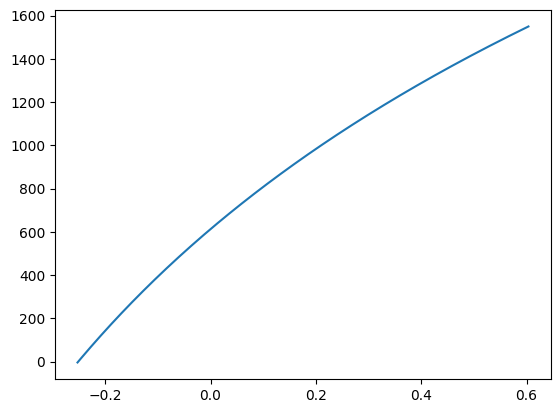

In [8]:
#set up simulation
from PySDM.dynamics import Condensation
import numpy as np
#Simulation is also in this folder
#Need to change/add/edit the Parcel environment PySDM/parcel to take in new dz that uses the 
#updraft and the terminal velocity to have the parcel track the superdroplet
simulation = Simulation(settings)
output = simulation.run()

#output currently has height, RH, radius, and time.. need others?
plt.plot(output['S'],output['z'])


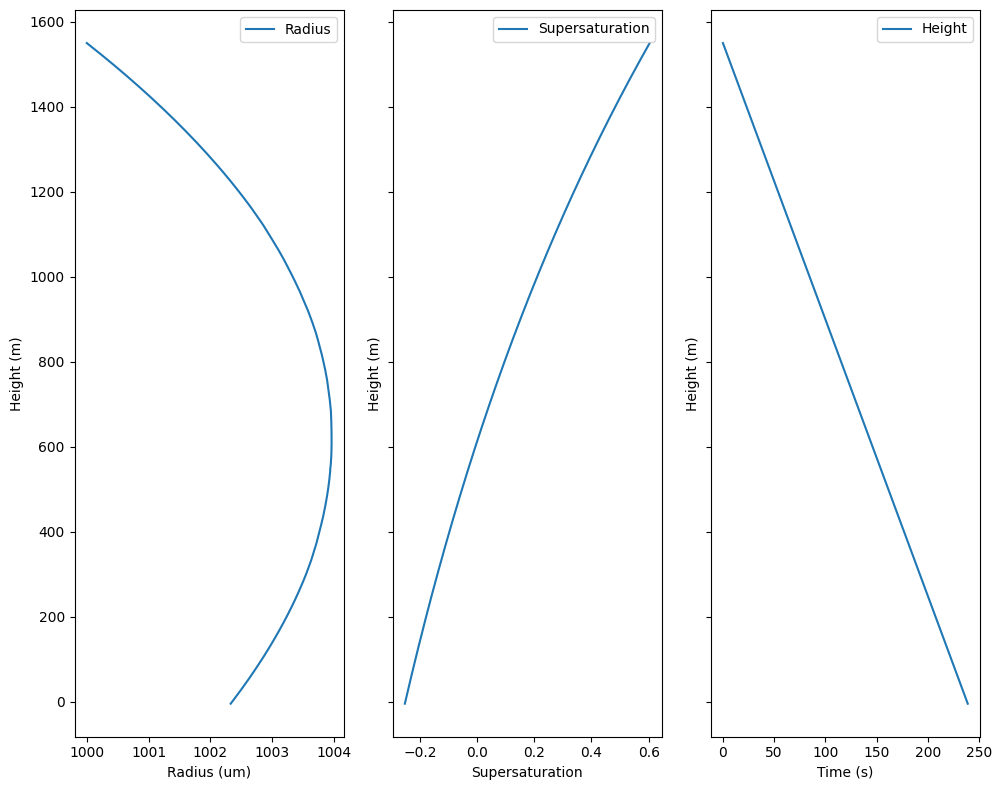

In [9]:
fig,axs = plt.subplots(1, 3, figsize=(10, 8),sharey=True)
axs[0].plot(output["r"], output["z"], label="Radius")
axs[0].set_ylabel("Height (m)")
axs[0].set_xlabel("Radius (um)")
axs[0].legend()
axs[1].plot(output["S"], output["z"], label="Supersaturation")
axs[1].set_xlabel("Supersaturation")
axs[1].set_ylabel("Height (m)")
axs[1].legend()
axs[2].plot(output["t"], output["z"], label="Height")
axs[2].set_ylabel("Height (m)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()
plt.tight_layout()